In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn import model_selection
import itertools
import shap

c:\Users\overw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data ingestion
training_dataset = pd.read_csv('cs-training.csv')
testing_dataset = pd.read_csv('cs-test.csv')

training_dataset.describe()
testing_dataset.describe()

# chekck columns for missing values
print("MISSING VALUES IN TRAINING DATASET")
print(training_dataset.isnull().sum())
print()
print("MISSING VALUES IN TESTING DATASET")
print(testing_dataset.isnull().sum())

# Column Unnamed: 0 is not needed
# Column SeriousDlqin2yrs is the target variable
# Column NumberOfDependents has missing values in both training and testing datasets
# Column MonthlyIncome has missing values in both training and testing datasets

MISSING VALUES IN TRAINING DATASET
Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

MISSING VALUES IN TESTING DATASET
Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans     

In [3]:
# Cleaning the data
# remove unnamed index column if it exists
try:
    training_dataset.drop('Unnamed: 0', axis=1, inplace=True)
    testing_dataset.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass

# missing data in the training dataset and testing dataset
training_dataset.fillna({'MonthlyIncome':0}, inplace=True)
training_dataset.fillna({"NumberOfDependents":0}, inplace=True) # changing these to 0 got me to 0.85857

testing_dataset.fillna({'MonthlyIncome':0}, inplace=True)
testing_dataset.fillna({"NumberOfDependents":0}, inplace=True)

In [4]:
# Assess class imbalance
print(training_dataset['SeriousDlqin2yrs'].value_counts())
# calculate class proportions
class_proportions = training_dataset['SeriousDlqin2yrs'].value_counts(normalize=True)























































































































































































































































































































































































































































































































































































































































































































































































































































gini_index = 1 - np.sum(class_proportions.values**2)
entropy = -np.sum(class_proportions.values * np.log2(class_proportions.values))
imbalance_ratio = class_proportions.max() / class_proportions.min()

print(f"Gini Index: {gini_index}")
print(f"Shannon Entropy: {entropy}")
print(f"Imbalance Ratio: {imbalance_ratio}")

# Gini Index: 0.1247 (low)      -> implies class imbalance
# Shannon Entropy: 0.3540 (low) -> implies class imbalance
# Imbalance Ratio: 13.0 (high)  -> implies class imbalance

# why AUC-ROC is a better metric than accuracy for imbalanced datasets
# Accuracy is not a good metric for imbalanced datasets because it does not take into account the class distribution.
# AUC-ROC is a better metric for imbalanced datasets because it considers the true positive rate and false positive rate across different thresholds.
# In this case, the AUC-ROC score will give a better indication regardless od the cuttodff value we use to determine defaulters and non-defaulters.

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64
Gini Index: 0.12474482879999993
Shannon Entropy: 0.35401892851338096
Imbalance Ratio: 13.961101137043688


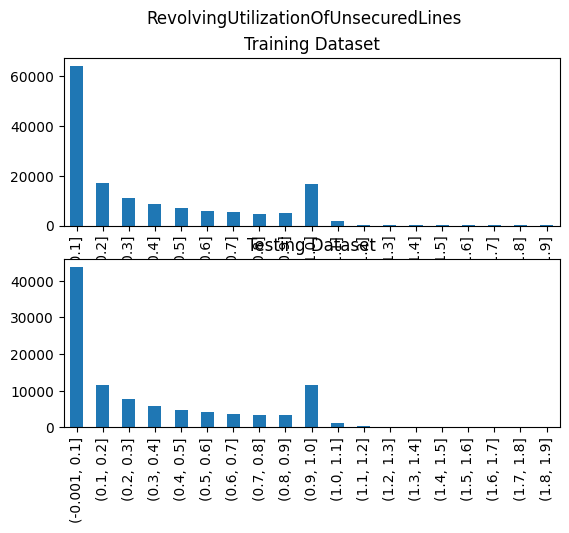

Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset:  97.63157448571562
Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset:  58.32498158936752
Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset after log:  11.704798483586039
Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset after log:  11.478386579833725


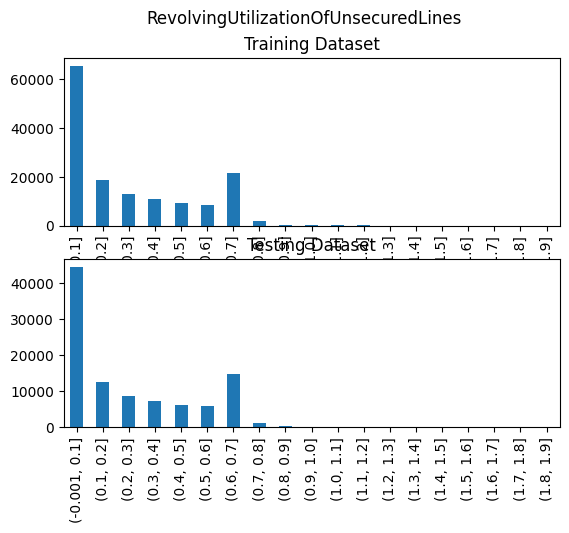

In [5]:
# Analysys of the RevolvingUtilizationOfUnsecuredLines Feature

# subplot 1: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['RevolvingUtilizationOfUnsecuredLines'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['RevolvingUtilizationOfUnsecuredLines'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('RevolvingUtilizationOfUnsecuredLines')
plt.show()

# calculate skewness
print("Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset: ", training_dataset['RevolvingUtilizationOfUnsecuredLines'].skew())
print("Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset: ", testing_dataset['RevolvingUtilizationOfUnsecuredLines'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['RevolvingUtilizationOfUnsecuredLines'] = np.log(training_dataset['RevolvingUtilizationOfUnsecuredLines'] + 1)
testing_dataset['RevolvingUtilizationOfUnsecuredLines'] = np.log(testing_dataset['RevolvingUtilizationOfUnsecuredLines'] + 1)

print("Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset after log: ", training_dataset['RevolvingUtilizationOfUnsecuredLines'].skew())
print("Skewness of RevolvingUtilizationOfUnsecuredLines in training dataset after log: ", testing_dataset['RevolvingUtilizationOfUnsecuredLines'].skew())

# subplot 1: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['RevolvingUtilizationOfUnsecuredLines'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['RevolvingUtilizationOfUnsecuredLines'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('RevolvingUtilizationOfUnsecuredLines')
plt.show()

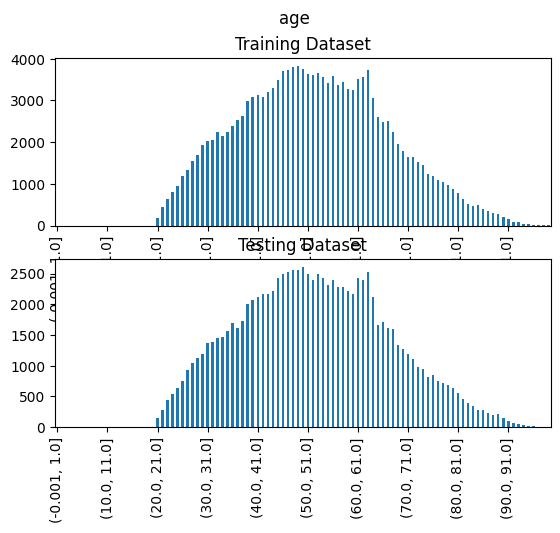

Skewness of age in training dataset:  0.18899454512676198
Skewness of age in training dataset:  0.18706568994589387


In [6]:
# Analysys of the'age Feature

# subplot 1:'age (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['age'].value_counts(bins=np.arange(0,100,1)).sort_index().plot(kind='bar')
plt.xticks(np.arange(0,100,10))
plt.title('Training Dataset')

# subplot 2: age (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['age'].value_counts(bins=np.arange(0,100,1)).sort_index().plot(kind='bar')
plt.xticks(np.arange(0,100,10))
plt.title('Testing Dataset')
# figure title
plt.suptitle('age')
plt.show()

# calculate skewness
print("Skewness of age in training dataset: ", training_dataset['age'].skew())
print("Skewness of age in training dataset: ", testing_dataset['age'].skew())

# data is not skewed

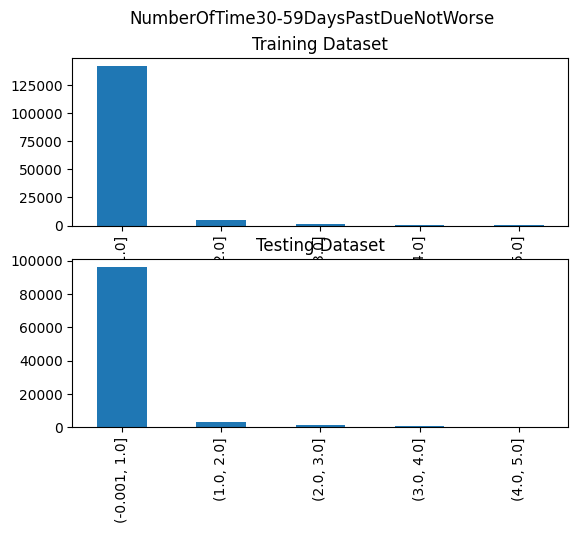

Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset:  22.597107559201046
Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset:  20.941243610195087
Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset after log:  4.272123488875267
Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset after log:  4.429935054169875


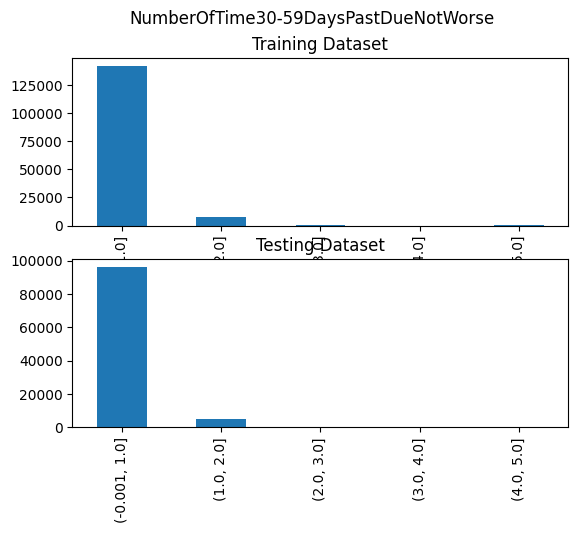

In [7]:
# Analysys of the NumberOfTime30-59DaysPastDueNotWorse Feature

# subplot 1: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTime30-59DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTime30-59DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTime30-59DaysPastDueNotWorse')
plt.show()

# calculate skewness
print("Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset: ", training_dataset['NumberOfTime30-59DaysPastDueNotWorse'].skew())
print("Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset: ", testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberOfTime30-59DaysPastDueNotWorse'] = np.log(training_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + 1)
testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'] = np.log(testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + 1)

print("Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset after log: ", training_dataset['NumberOfTime30-59DaysPastDueNotWorse'].skew())
print("Skewness of NumberOfTime30-59DaysPastDueNotWorse in training dataset after log: ", testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'].skew())

# subplot 1: NumberOfTime30-59DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTime30-59DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTime30-59DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTime30-59DaysPastDueNotWorse')
plt.show()

# data is still skewed but much less than before

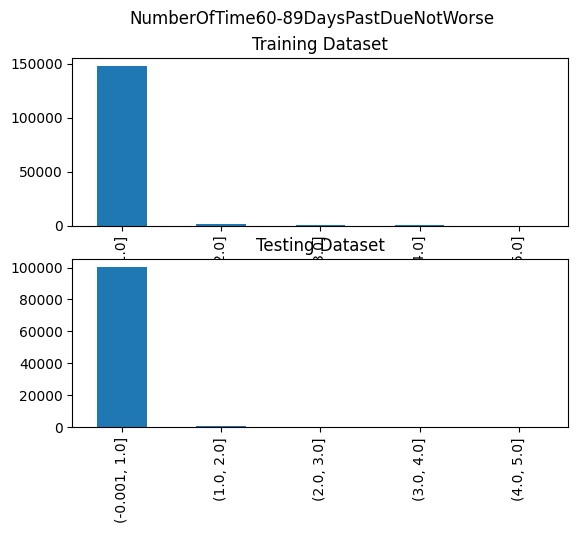

Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset:  23.33174311951399
Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset:  21.541430720811885
Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset after log:  10.60585337020412
Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset after log:  10.75161701130321


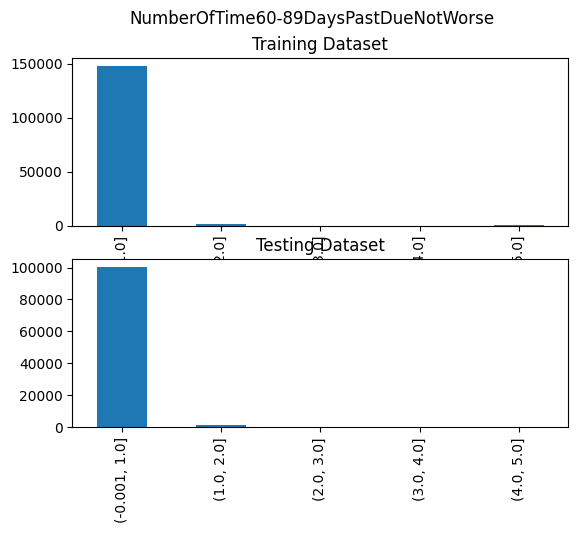

In [8]:
# Analysys of the NumberOfTime60-89DaysPastDueNotWorse Feature

# subplot 1: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTime60-89DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTime60-89DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTime60-89DaysPastDueNotWorse')
plt.show()

# calculate skewness
print("Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset: ", training_dataset['NumberOfTime60-89DaysPastDueNotWorse'].skew())
print("Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset: ", testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberOfTime60-89DaysPastDueNotWorse'] = np.log(training_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + 1)
testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'] = np.log(testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + 1)

print("Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset after log: ", training_dataset['NumberOfTime60-89DaysPastDueNotWorse'].skew())
print("Skewness of NumberOfTime60-89DaysPastDueNotWorse in training dataset after log: ", testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'].skew())

# subplot 1: NumberOfTime60-89DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTime60-89DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTime60-89DaysPastDueNotWorse (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTime60-89DaysPastDueNotWorse')
plt.show()

# data is still skewed but less than before

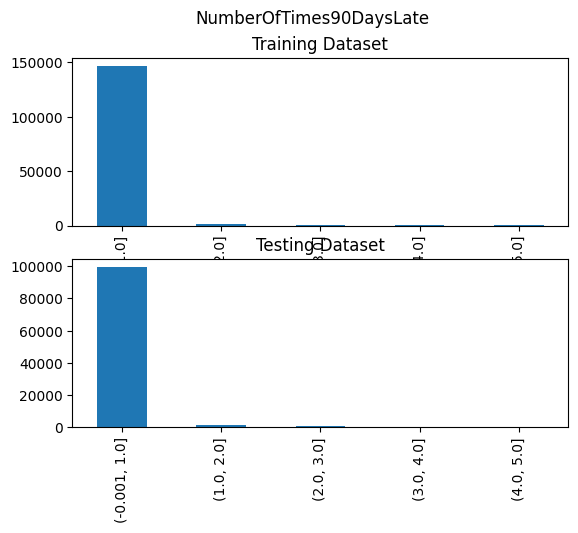

Skewness of NumberOfTimes90DaysLate in training dataset:  23.087345471932874
Skewness of NumberOfTimes90DaysLate in training dataset:  21.355956334753017
Skewness of NumberOfTimes90DaysLate in training dataset after log:  8.810638773211291
Skewness of NumberOfTimes90DaysLate in training dataset after log:  8.929961492100615


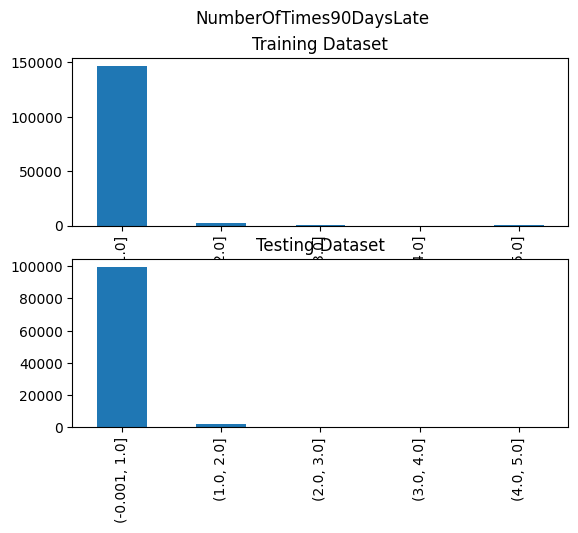

In [9]:
# Analysys of the NumberOfTimes90DaysLate Feature

# subplot 1: RevolvingUtilizationOfUnsecuredLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTimes90DaysLate'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTimes90DaysLate (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTimes90DaysLate'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTimes90DaysLate')
plt.show()

# calculate skewness
print("Skewness of NumberOfTimes90DaysLate in training dataset: ", training_dataset['NumberOfTimes90DaysLate'].skew())
print("Skewness of NumberOfTimes90DaysLate in training dataset: ", testing_dataset['NumberOfTimes90DaysLate'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberOfTimes90DaysLate'] = np.log(training_dataset['NumberOfTimes90DaysLate'] + 1)
testing_dataset['NumberOfTimes90DaysLate'] = np.log(testing_dataset['NumberOfTimes90DaysLate'] + 1)

print("Skewness of NumberOfTimes90DaysLate in training dataset after log: ", training_dataset['NumberOfTimes90DaysLate'].skew())
print("Skewness of NumberOfTimes90DaysLate in training dataset after log: ", testing_dataset['NumberOfTimes90DaysLate'].skew())

# subplot 1: NumberOfTimes90DaysLate (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfTimes90DaysLate'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfTimes90DaysLate (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfTimes90DaysLate'].value_counts(bins=np.arange(0,6,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfTimes90DaysLate')
plt.show()

# data is still skewed but less than before

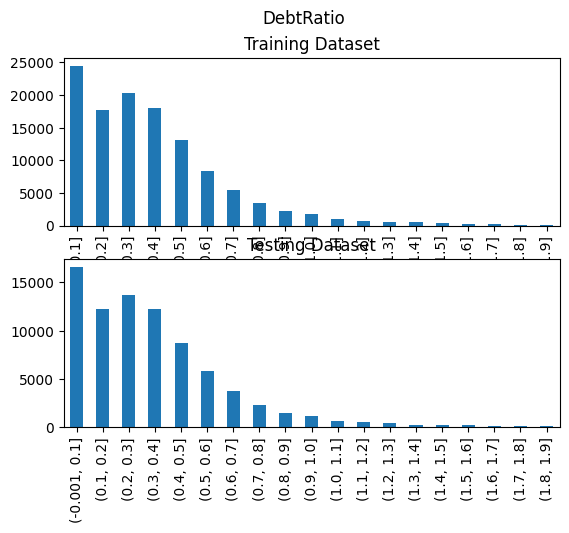

Skewness of DebtRatio in training dataset:  95.15779286552785
Skewness of DebtRatio in training dataset:  73.19085993608266
Skewness of DebtRatio in training dataset after log:  1.7490132141424464
Skewness of DebtRatio in training dataset after log:  1.7608461401309163


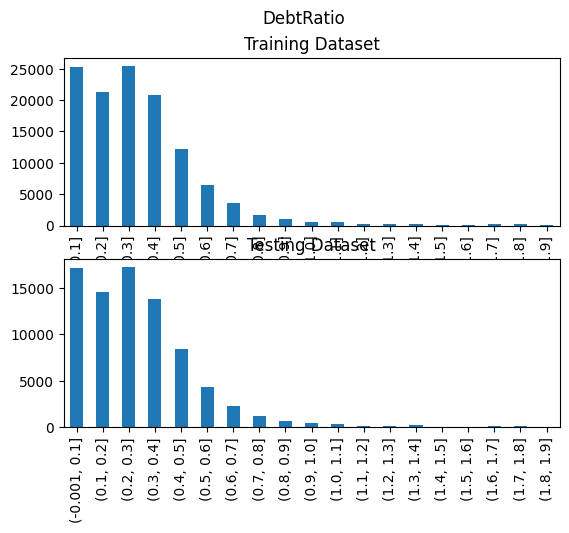

In [10]:
# Analysys of the DebtRatio Feature

# subplot 1: DebtRatio (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['DebtRatio'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: DebtRatio (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['DebtRatio'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('DebtRatio')
plt.show()

# calculate skewness
print("Skewness of DebtRatio in training dataset: ", training_dataset['DebtRatio'].skew())
print("Skewness of DebtRatio in training dataset: ", testing_dataset['DebtRatio'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['DebtRatio'] = np.log(training_dataset['DebtRatio'] + 1)
testing_dataset['DebtRatio'] = np.log(testing_dataset['DebtRatio'] + 1)

print("Skewness of DebtRatio in training dataset after log: ", training_dataset['DebtRatio'].skew())
print("Skewness of DebtRatio in training dataset after log: ", testing_dataset['DebtRatio'].skew())

# subplot 1: DebtRatio (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['DebtRatio'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: DebtRatio (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['DebtRatio'].value_counts(bins=np.arange(0,2,.1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('DebtRatio')
plt.show()

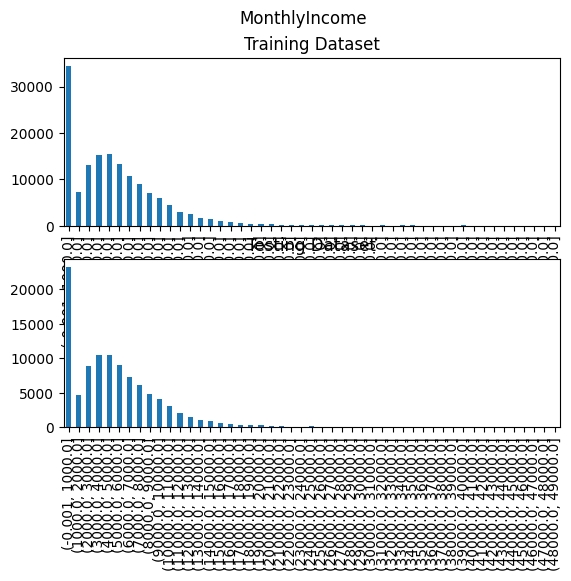

Skewness of MonthlyIncome in training dataset:  119.90607913104274
Skewness of MonthlyIncome in training dataset:  176.06822121478993
Skewness of MonthlyIncome in training dataset after log:  -1.2918068502157436
Skewness of MonthlyIncome in training dataset after log:  -1.298978468263757


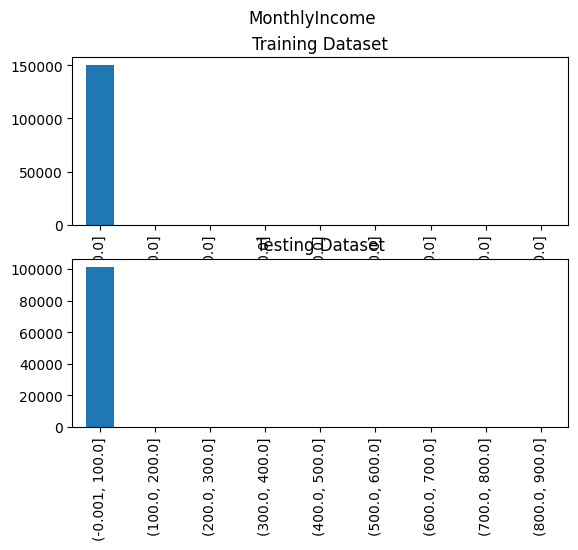

In [11]:

# subplot 1: MonthlyIncome (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['MonthlyIncome'].value_counts(bins=np.arange(0,50000,1000)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: MonthlyIncome (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['MonthlyIncome'].value_counts(bins=np.arange(0,50000,1000)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('MonthlyIncome')
plt.show()

# calculate skewness
print("Skewness of MonthlyIncome in training dataset: ", training_dataset['MonthlyIncome'].skew())
print("Skewness of MonthlyIncome in training dataset: ", testing_dataset['MonthlyIncome'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['MonthlyIncome'] = np.log(training_dataset['MonthlyIncome'] + 1)
testing_dataset['MonthlyIncome'] = np.log(testing_dataset['MonthlyIncome'] + 1)

print("Skewness of MonthlyIncome in training dataset after log: ", training_dataset['MonthlyIncome'].skew())
print("Skewness of MonthlyIncome in training dataset after log: ", testing_dataset['MonthlyIncome'].skew())

# subplot 1: MonthlyIncome (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['MonthlyIncome'].value_counts(bins=np.arange(0,1000,100)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: MonthlyIncome (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['MonthlyIncome'].value_counts(bins=np.arange(0,1000,100)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('MonthlyIncome')
plt.show()

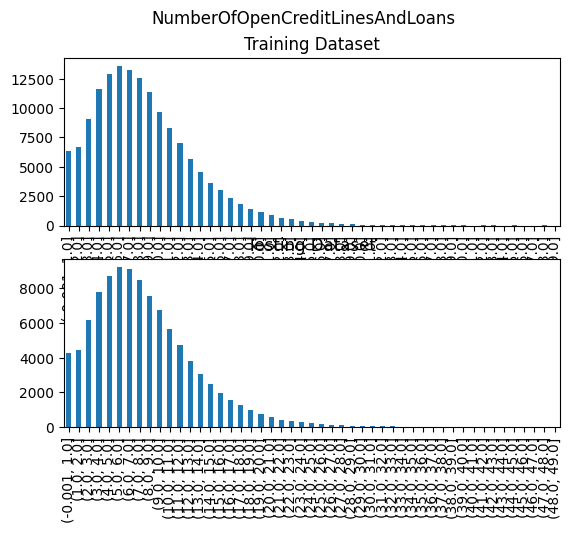

Skewness of NumberOfOpenCreditLinesAndLoans in training dataset:  1.2153137802048144
Skewness of NumberOfOpenCreditLinesAndLoans in training dataset:  1.2252293916437713
Skewness of NumberOfOpenCreditLinesAndLoans in training dataset after log:  -0.7330808531326161
Skewness of NumberOfOpenCreditLinesAndLoans in training dataset after log:  -0.7302106103191367


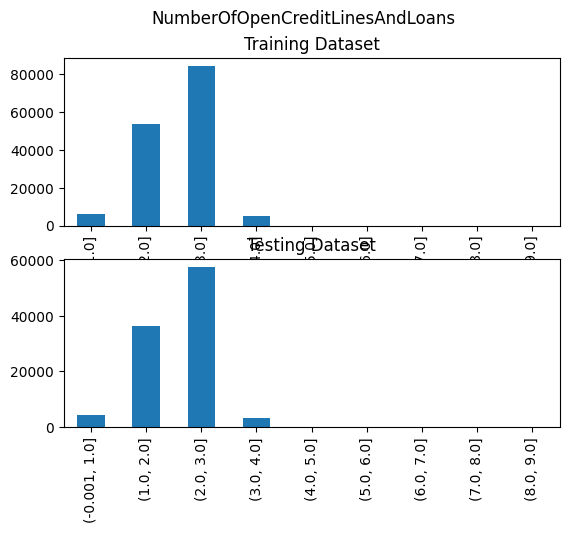

In [12]:
# Analysys of the NumberOfOpenCreditLinesAndLoans Feature

# subplot 1: NumberOfOpenCreditLinesAndLoans (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfOpenCreditLinesAndLoans'].value_counts(bins=np.arange(0,50,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfOpenCreditLinesAndLoans (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfOpenCreditLinesAndLoans'].value_counts(bins=np.arange(0,50,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfOpenCreditLinesAndLoans')
plt.show()

# calculate skewness
print("Skewness of NumberOfOpenCreditLinesAndLoans in training dataset: ", training_dataset['NumberOfOpenCreditLinesAndLoans'].skew())
print("Skewness of NumberOfOpenCreditLinesAndLoans in training dataset: ", testing_dataset['NumberOfOpenCreditLinesAndLoans'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberOfOpenCreditLinesAndLoans'] = np.log(training_dataset['NumberOfOpenCreditLinesAndLoans'] + 1)
testing_dataset['NumberOfOpenCreditLinesAndLoans'] = np.log(testing_dataset['NumberOfOpenCreditLinesAndLoans'] + 1)

print("Skewness of NumberOfOpenCreditLinesAndLoans in training dataset after log: ", training_dataset['NumberOfOpenCreditLinesAndLoans'].skew())
print("Skewness of NumberOfOpenCreditLinesAndLoans in training dataset after log: ", testing_dataset['NumberOfOpenCreditLinesAndLoans'].skew())

# subplot 1: NumberOfOpenCreditLinesAndLoans (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfOpenCreditLinesAndLoans'].value_counts(bins=np.arange(0,10,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfOpenCreditLinesAndLoans (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfOpenCreditLinesAndLoans'].value_counts(bins=np.arange(0,10,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfOpenCreditLinesAndLoans')
plt.show()

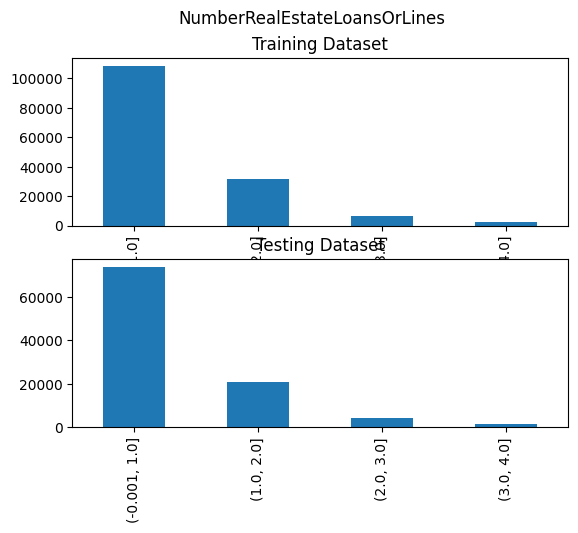

Skewness of NumberRealEstateLoansOrLines in training dataset:  3.482483993516935
Skewness of NumberRealEstateLoansOrLines in training dataset:  2.790100976235187
Skewness of NumberRealEstateLoansOrLines in training dataset after log:  0.2388331176943943
Skewness of NumberRealEstateLoansOrLines in training dataset after log:  0.2333693665201205


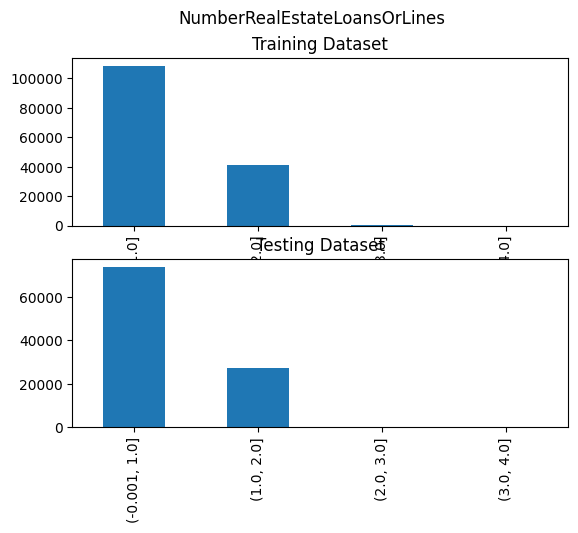

In [13]:
# Analysys of the NumberRealEstateLoansOrLines Feature

# subplot 1: NumberRealEstateLoansOrLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberRealEstateLoansOrLines'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberRealEstateLoansOrLines (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberRealEstateLoansOrLines'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberRealEstateLoansOrLines')
plt.show()

# calculate skewness
print("Skewness of NumberRealEstateLoansOrLines in training dataset: ", training_dataset['NumberRealEstateLoansOrLines'].skew())
print("Skewness of NumberRealEstateLoansOrLines in training dataset: ", testing_dataset['NumberRealEstateLoansOrLines'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberRealEstateLoansOrLines'] = np.log(training_dataset['NumberRealEstateLoansOrLines'] + 1)
testing_dataset['NumberRealEstateLoansOrLines'] = np.log(testing_dataset['NumberRealEstateLoansOrLines'] + 1)

print("Skewness of NumberRealEstateLoansOrLines in training dataset after log: ", training_dataset['NumberRealEstateLoansOrLines'].skew())
print("Skewness of NumberRealEstateLoansOrLines in training dataset after log: ", testing_dataset['NumberRealEstateLoansOrLines'].skew())

# subplot 1: NumberRealEstateLoansOrLines (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberRealEstateLoansOrLines'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberRealEstateLoansOrLines (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberRealEstateLoansOrLines'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberRealEstateLoansOrLines')
plt.show()

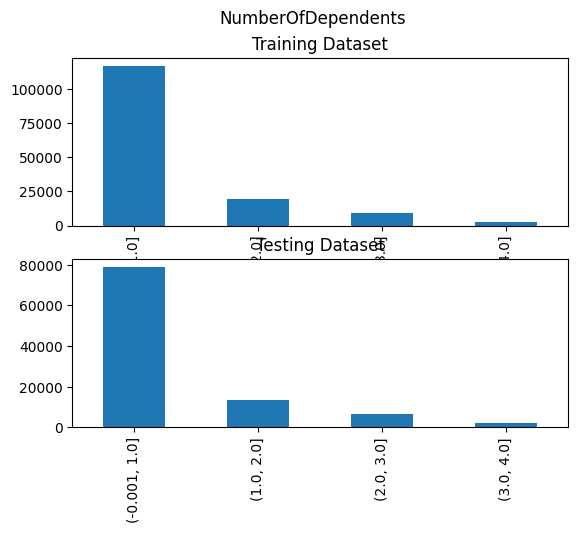

Skewness of NumberOfDependents in training dataset:  1.6260587679259588
Skewness of NumberOfDependents in training dataset:  2.1112086042401277
Skewness of NumberOfDependents in training dataset after log:  0.8764854862356278
Skewness of NumberOfDependents in training dataset after log:  0.8700864717471689


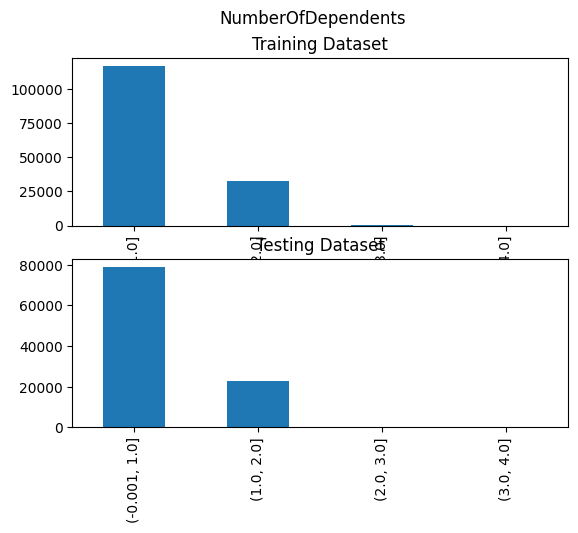

In [14]:
# Analysys of the NumberOfDependents Feature

# subplot 1: NumberOfDependents") (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfDependents'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfDependents (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfDependents'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfDependents')
plt.show()

# calculate skewness
print("Skewness of NumberOfDependents in training dataset: ", training_dataset['NumberOfDependents'].skew())
print("Skewness of NumberOfDependents in training dataset: ", testing_dataset['NumberOfDependents'].skew())

# data is skewed to the right
# apply log transformation to reduce skewness
training_dataset['NumberOfDependents'] = np.log(training_dataset['NumberOfDependents'] + 1)
testing_dataset['NumberOfDependents'] = np.log(testing_dataset['NumberOfDependents'] + 1)

print("Skewness of NumberOfDependents in training dataset after log: ", training_dataset['NumberOfDependents'].skew())
print("Skewness of NumberOfDependents in training dataset after log: ", testing_dataset['NumberOfDependents'].skew())

# subplot 1: NumberOfDependents (training dataset)
plt.subplot(2, 1, 1)
# use bins of 100 $
training_dataset['NumberOfDependents'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Training Dataset')

# subplot 2: NumberOfDependents (training dataset)
plt.subplot(2, 1, 2)
testing_dataset['NumberOfDependents'].value_counts(bins=np.arange(0,5,1)).sort_index().plot(kind='bar')
plt.title('Testing Dataset')
# figure title
plt.suptitle('NumberOfDependents')
plt.show()

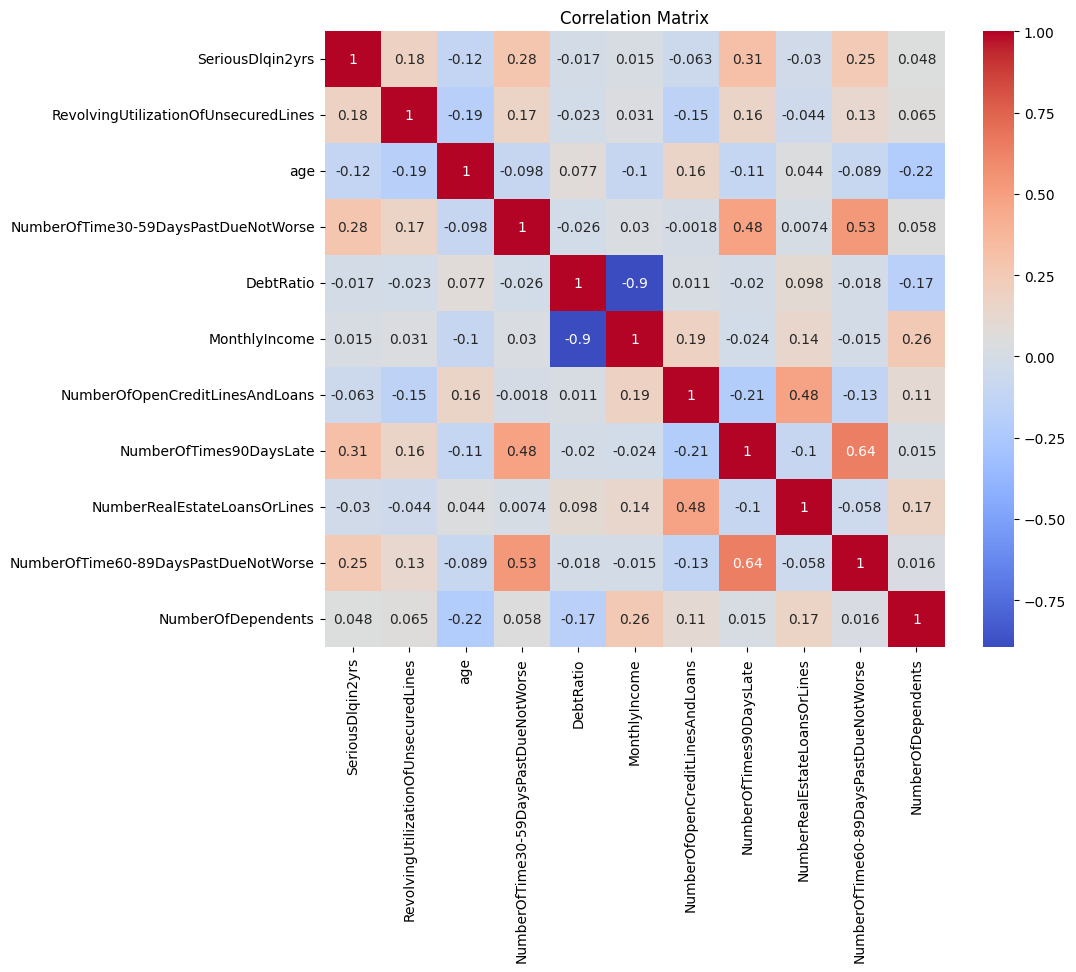

In [15]:
# plot the correlation matrix to see the relationship between the features
plt.figure(figsize=(10, 8))
sns.heatmap(training_dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
# feature engineering -> This got me to 0.78485
training_dataset['MonthlyDebt'] = training_dataset['MonthlyIncome'] * training_dataset['DebtRatio']
training_dataset['MonthlyBalance'] = training_dataset['MonthlyIncome'] - training_dataset['MonthlyDebt']
training_dataset['NumberOfTimesPastDue'] = training_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + training_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + training_dataset['NumberOfTimes90DaysLate']

testing_dataset['MonthlyDebt'] = testing_dataset['MonthlyIncome'] * testing_dataset['DebtRatio']
testing_dataset['MonthlyBalance'] = testing_dataset['MonthlyIncome'] - testing_dataset['MonthlyDebt']
testing_dataset['NumberOfTimesPastDue'] = testing_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + testing_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + testing_dataset['NumberOfTimes90DaysLate']

training_dataset["IncomePerDependent"] = training_dataset["MonthlyIncome"] / (training_dataset["NumberOfDependents"] + 1)
testing_dataset["IncomePerDependent"] = testing_dataset["MonthlyIncome"] / (testing_dataset["NumberOfDependents"] + 1)

training_dataset["MonthlyBalancePerDependent"] = training_dataset["MonthlyBalance"] / (training_dataset["NumberOfDependents"] + 1)
testing_dataset["MonthlyBalancePerDependent"] = testing_dataset["MonthlyBalance"] / (testing_dataset["NumberOfDependents"] + 1)

# replace NaNs with 0
training_dataset.fillna(0, inplace=True)
testing_dataset.fillna(0, inplace=True)

# drop columns that are not needed
training_dataset.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfDependents'], axis=1, inplace=True)
testing_dataset.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfDependents'], axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation Matrix')

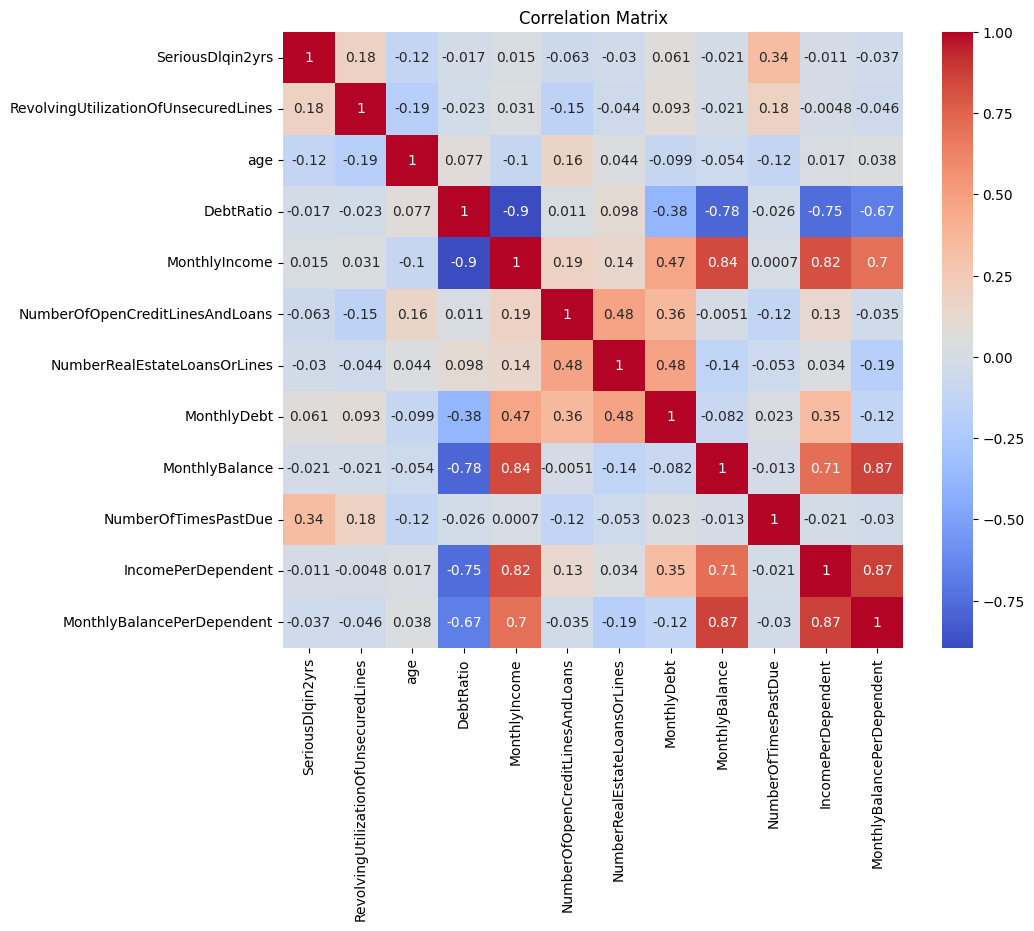

In [17]:
# plot the correlation matrix to see the relationship between the new features
plt.figure(figsize=(10, 8))
sns.heatmap(training_dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [18]:
# Data Transformation

# split the dataset into features and target
features = training_dataset.drop('SeriousDlqin2yrs', axis=1).values
target = training_dataset['SeriousDlqin2yrs'].values

# split the dataset into training and validation
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)

Epoch 1/25, Train Loss: 0.1868, Val Loss: 0.1784
Epoch 2/25, Train Loss: 0.1813, Val Loss: 0.1783
Epoch 3/25, Train Loss: 0.1808, Val Loss: 0.1777
Epoch 4/25, Train Loss: 0.1804, Val Loss: 0.1771
Epoch 5/25, Train Loss: 0.1799, Val Loss: 0.1789
Epoch 6/25, Train Loss: 0.1796, Val Loss: 0.1773
Epoch 7/25, Train Loss: 0.1795, Val Loss: 0.1778
Epoch 8/25, Train Loss: 0.1794, Val Loss: 0.1772
Epoch 9/25, Train Loss: 0.1790, Val Loss: 0.1763
Epoch 10/25, Train Loss: 0.1789, Val Loss: 0.1762
Epoch 11/25, Train Loss: 0.1786, Val Loss: 0.1774
Epoch 12/25, Train Loss: 0.1787, Val Loss: 0.1766
Epoch 13/25, Train Loss: 0.1784, Val Loss: 0.1771
Epoch 14/25, Train Loss: 0.1783, Val Loss: 0.1770
Epoch 15/25, Train Loss: 0.1782, Val Loss: 0.1766
Epoch 16/25, Train Loss: 0.1781, Val Loss: 0.1786
Epoch 17/25, Train Loss: 0.1777, Val Loss: 0.1769
Epoch 18/25, Train Loss: 0.1777, Val Loss: 0.1773
Epoch 19/25, Train Loss: 0.1776, Val Loss: 0.1772
Epoch 20/25, Train Loss: 0.1775, Val Loss: 0.1773
Epoch 21/

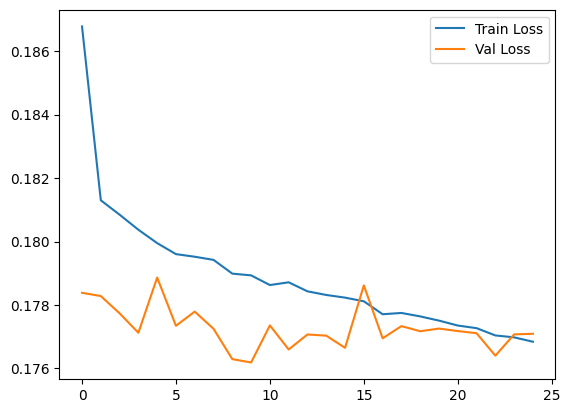

In [19]:
# 3 layer NN model with dropout

class CreditScoreDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.target[idx], dtype=torch.float32)
    
class CreditScoreModel(nn.Module):
    def __init__(self, input_size, dropout):
        super(CreditScoreModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
# create the dataset
train_dataset = CreditScoreDataset(features_train, target_train)
val_dataset = CreditScoreDataset(features_val, target_val)

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# LOSS FUNCTION: Binary Cross Entropy
# OPTIMIZER: Adam

# define the model
model = CreditScoreModel(features_train.shape[1], dropout=0.2)

# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model
num_epochs = 25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train() # this enables dropout and batch normalization
    train_loss = 0 # accumulate the training loss here
    for features_batch, target_batch in train_loader: # iterate over the dataloader
        optimizer.zero_grad() # set the gradients to zero
        target_pred = model(features_batch) # forward pass
        loss = criterion(target_pred, target_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features_batch, target_batch in val_loader:
            target_pred = model(features_batch)
            loss = criterion(target_pred, target_batch.unsqueeze(1))
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [20]:
# use model to predict the test dataset
features_test = testing_dataset.drop('SeriousDlqin2yrs', axis=1).values
target_test = testing_dataset['SeriousDlqin2yrs'].values

features_test = scaler.transform(features_test)
test_dataset = CreditScoreDataset(features_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
target_pred = []
with torch.no_grad():
    for features_batch, target_batch in test_loader:
        target_pred_batch = model(features_batch)
        target_pred.extend(target_pred_batch.numpy().flatten())

y_pred = np.array(target_pred)

In [21]:
import lime
import lime.lime_tabular

X = training_dataset.drop('SeriousDlqin2yrs', axis=1).values
y = training_dataset['SeriousDlqin2yrs'].values

explainer = lime.lime_tabular.LimeTabularExplainer(
    X, 
    mode="classification", 
    feature_names=training_dataset.drop('SeriousDlqin2yrs', axis=1).columns.values, 
    class_names=['Not Delinquent', 'Delinquent'], 
    discretize_continuous=True
)
def predict_proba(X):
    model.eval()
    with torch.no_grad():
        tensor_X = torch.tensor(X, dtype=torch.float32)
        predictions = model(tensor_X).numpy()
    return np.hstack((1 - predictions, predictions))

# Select an instance to explain
instance_idx = 195
instance = X[instance_idx]

# Generate LIME explanation
explanation = explainer.explain_instance(instance, predict_proba, num_features=5)

# Visualize the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

# If running in a script or IDE, use the following:
explanation.save_to_file('lime_explanation.html')

In [22]:
# replace missing values with the median
y_pred = np.where(np.isnan(y_pred), np.average(y_pred[~np.isnan(y_pred)]), y_pred)

#check the length of the prediction
len(y_pred)
assert len(y_pred) == len(testing_dataset)

# length of the prediction should be the same as the number of rows in the test dataset
output_df = pd.DataFrame({'Id': range(1, len(y_pred)+1), 'Probability': y_pred})


time_of_run = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
print(f"Submission file created at {time_of_run}")
output_df.to_csv(f'submission{time_of_run}.csv', index=False, header=True)

# copy the submission file to the submission folder
import shutil

# create directory
shutil.os.makedirs(f'submissions/{time_of_run}/')

shutil.copy(f'submission{time_of_run}.csv', f'submissions/{time_of_run}/')
#copy the ipynb file to the submissions folder
shutil.copy('GMSC.ipynb', f'submissions/{time_of_run}/')

# delete the submission file
shutil.os.remove(f'submission{time_of_run}.csv')	

Submission file created at 2024-06-21_10-48-49


In [23]:
def xgbCV(eta=[0.05],max_depth=[6],sub_sample=[0.9],colsample_bytree=[0.9]):

    train_X = training_dataset.drop(['SeriousDlqin2yrs'], axis=1) # features for training data
    test_X = testing_dataset.drop(['SeriousDlqin2yrs'], axis=1) # features for testing data
    train_y = training_dataset['SeriousDlqin2yrs'] # label for training data

    if 'ID' in train_X.columns.values:
        train_X.drop(['ID'], axis=1, inplace=True)
    if 'ID' in test_X.columns.values:
        test_X.drop(['ID'], axis=1, inplace=True)
    skf = model_selection.StratifiedKFold(n_splits=5) # stratified sampling
    train_performance ={} 
    val_performance={}
    for each_param in itertools.product(eta,max_depth,sub_sample,colsample_bytree): # iterative over each combination in parameter space
        xgb_params = {
                    'eta':each_param[0],
                    'max_depth':each_param[1],
                    'colsample_bytree':each_param[3],
                    'objective':'binary:logistic',
                    'eval_metric':'auc'
                    }
        best_iteration =[]
        best_score=[]
        training_score=[]
        for train_ind,val_ind in skf.split(train_X,train_y): # five fold stratified cross validation
            X_train,X_val = train_X.iloc[train_ind,],train_X.iloc[val_ind,] # train X and train y
            y_train,y_val = train_y.iloc[train_ind],train_y.iloc[val_ind] # validation X and validation y
            dtrain = xgb.DMatrix(X_train,y_train,feature_names = list(X_train.columns.values)) # convert into DMatrix (xgb library data structure)
            dval = xgb.DMatrix(X_val,y_val,feature_names = list(X_val.columns.values)) # convert into DMatrix (xgb library data structure)
            model = xgb.train(xgb_params,dtrain,num_boost_round=1000,evals=[(dtrain,'train'),(dval,'val')],verbose_eval=False,early_stopping_rounds=30) # train the model

            print(model.attributes())

            best_iteration.append(model.attributes()['best_iteration']) # best iteration regarding AUC in valid set
            best_score.append(model.attributes()['best_score']) # best score regarding AUC in valid set
        valid_mean = (np.asarray(best_score).astype(float).mean()) # mean AUC in valid set
        train_mean = (np.asarray(training_score).astype(float).mean()) # mean AUC in training set
        val_performance[each_param] =  train_mean
        train_performance[each_param] =  valid_mean
        print ("Parameters are {}. Training performance is {:.4f}. Validation performance is {:.4f}".format(each_param,train_mean,valid_mean))
    return (train_performance,val_performance)

#xgbCV(eta=[0.01,0.02,0.03,0.04,0.05],max_depth=[4,6,8,10],colsample_bytree=[0.3,0.5,0.7,0.9]) 
xgbCV(eta=[0.04],max_depth=[4],colsample_bytree=[0.5])

# 

{'best_iteration': '213', 'best_score': '0.8627232095953334'}
{'best_iteration': '188', 'best_score': '0.8603411011674243'}
{'best_iteration': '276', 'best_score': '0.8644195547922479'}
{'best_iteration': '368', 'best_score': '0.864488261396874'}
{'best_iteration': '333', 'best_score': '0.8699696463431527'}
Parameters are (0.04, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8644


C:\Users\overw\AppData\Local\Temp\ipykernel_28604\4242533545.py:37: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(float).mean()) # mean AUC in training set
c:\Users\overw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


({(0.04, 4, 0.9, 0.5): 0.8643883546590064}, {(0.04, 4, 0.9, 0.5): nan})

[0]	train-auc:0.84059
[1]	train-auc:0.84977
[2]	train-auc:0.85649
[3]	train-auc:0.85374
[4]	train-auc:0.85483
[5]	train-auc:0.85189
[6]	train-auc:0.84840
[7]	train-auc:0.84560
[8]	train-auc:0.84448
[9]	train-auc:0.84422
[10]	train-auc:0.84183
[11]	train-auc:0.84915
[12]	train-auc:0.85301
[13]	train-auc:0.85665
[14]	train-auc:0.85873
[15]	train-auc:0.85780
[16]	train-auc:0.85867
[17]	train-auc:0.85788
[18]	train-auc:0.85798
[19]	train-auc:0.85940
[20]	train-auc:0.85928
[21]	train-auc:0.86027
[22]	train-auc:0.86032
[23]	train-auc:0.86113
[24]	train-auc:0.86106
[25]	train-auc:0.86182
[26]	train-auc:0.86217
[27]	train-auc:0.86256
[28]	train-auc:0.86250
[29]	train-auc:0.86279
[30]	train-auc:0.86305
[31]	train-auc:0.86309
[32]	train-auc:0.86322
[33]	train-auc:0.86332
[34]	train-auc:0.86332
[35]	train-auc:0.86345
[36]	train-auc:0.86360
[37]	train-auc:0.86356
[38]	train-auc:0.86376
[39]	train-auc:0.86370
[40]	train-auc:0.86369
[41]	train-auc:0.86366
[42]	train-auc:0.86367
[43]	train-auc:0.8635

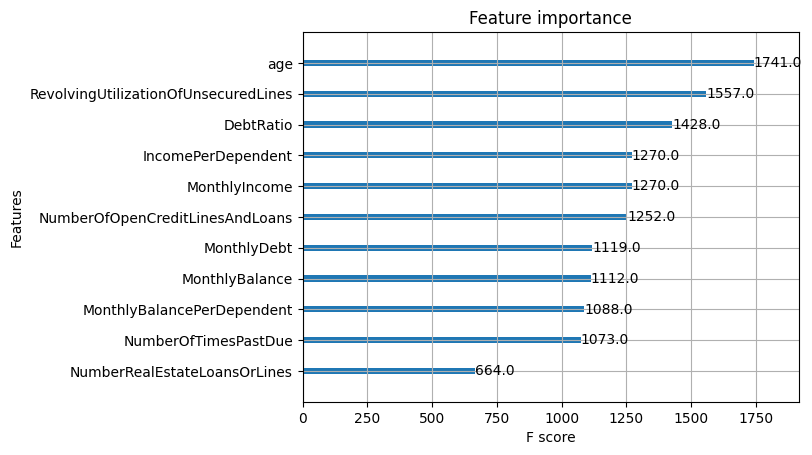

In [24]:
train_X = training_dataset.drop(['SeriousDlqin2yrs'], axis=1) # features for training data
test_X = testing_dataset.drop(['SeriousDlqin2yrs'], axis=1) # features for testing data
train_y = training_dataset['SeriousDlqin2yrs'] # label for training data

# train the model with the best parameters
xgb_params = {
'eta':0.04,
'max_depth':4,
'colsample_bytree':0.5,
'objective':'binary:logistic',
'eval_metric':'auc'
}

dtrain = xgb.DMatrix(train_X,train_y,feature_names = train_X.columns.tolist())
dtest = xgb.DMatrix(test_X,feature_names = test_X.columns.tolist())
model = xgb.train(xgb_params,dtrain,num_boost_round=1000,evals=[(dtrain,'train')],verbose_eval=True,early_stopping_rounds=30)
xgb.plot_importance(model)
# plt.show()

# predict the test dataset
y_pred = model.predict(dtest)

# replace missing values with the median
y_pred = np.where(np.isnan(y_pred), np.average(y_pred[~np.isnan(y_pred)]), y_pred)
# length of the prediction should be the same as the number of rows in the test dataset
output_df = pd.DataFrame({'Id': range(1, len(y_pred)+1), 'Probability': y_pred})

len(y_pred)

time_of_run = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
print(f"Submission file created at {time_of_run}")
output_df.to_csv(f'submission{time_of_run}.csv', index=False, header=True)

# copy the submission file to the submission folder
import shutil

# create directory
shutil.os.makedirs(f'submissions/{time_of_run}/')

shutil.copy(f'submission{time_of_run}.csv', f'submissions/{time_of_run}/')
#copy the ipynb file to the submissions folder
shutil.copy('GMSC.ipynb', f'submissions/{time_of_run}/')

# delete the submission file
shutil.os.remove(f'submission{time_of_run}.csv')

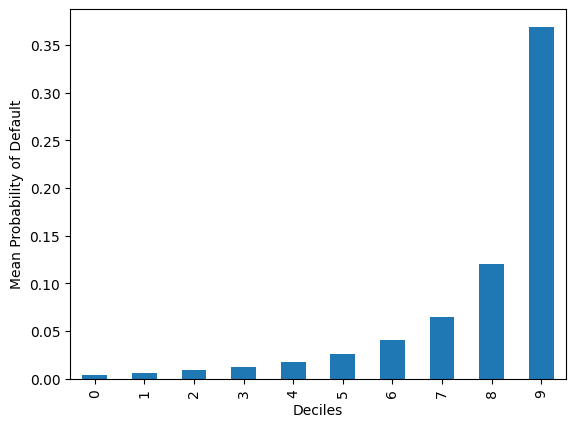

In [25]:
# join predictions to the test dataset
test_X['Probability'] = y_pred
#CALCULATE the deciles
test_X['Deciles'] = pd.qcut(test_X['Probability'],10,labels=False)
# plot the mean probability of default for each decile
test_X.groupby('Deciles')['Probability'].mean().plot(kind='bar')

plt.xlabel('Deciles')
plt.ylabel('Mean Probability of Default')
plt.show()

# Comments:

# The plot shows that the model is able to differentiate between low and high risk customers.
# This could later be used to segment customers into different risk categories and offer different products to each segment.

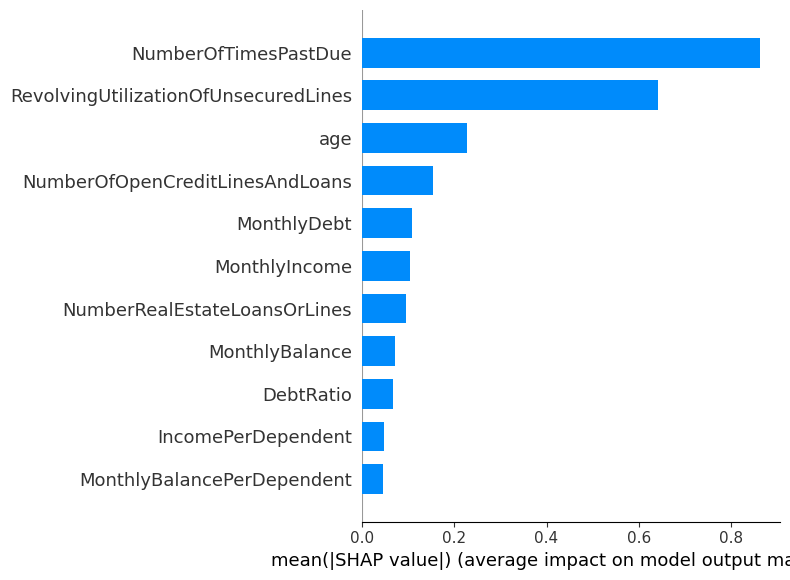

In [26]:
# use SHAP values to explain the model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X.drop(['Probability','Deciles'], axis=1))

shap.summary_plot(shap_values, test_X.drop(['Probability','Deciles'], axis=1), plot_type='bar')